In [63]:
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

PermanentCrop vs Forest

In [64]:
DATASET_PATH = "datasets/EuroSAT/"
CSV_PATH = DATASET_PATH + "train.csv"

num_samples = 200
df = pd.read_csv(CSV_PATH)

subset = df[df["ClassName"].isin(["PermanentCrop", "Forest"])].head(num_samples)
subset.reset_index(drop=True, inplace=True)
subset


,Unnamed: 0,Filename,Label,ClassName
0,17881,PermanentCrop/PermanentCrop_1073.jpg,6,PermanentCrop
1,17217,PermanentCrop/PermanentCrop_1356.jpg,6,PermanentCrop
2,18425,PermanentCrop/PermanentCrop_2349.jpg,6,PermanentCrop
3,8233,Forest/Forest_1951.jpg,1,Forest
4,17405,PermanentCrop/PermanentCrop_336.jpg,6,PermanentCrop
...,...,...,...,...
195,18362,PermanentCrop/PermanentCrop_1.jpg,6,PermanentCrop
196,7629,Forest/Forest_556.jpg,1,Forest
197,7960,Forest/Forest_2315.jpg,1,Forest
198,8686,Forest/Forest_1314.jpg,1,Forest


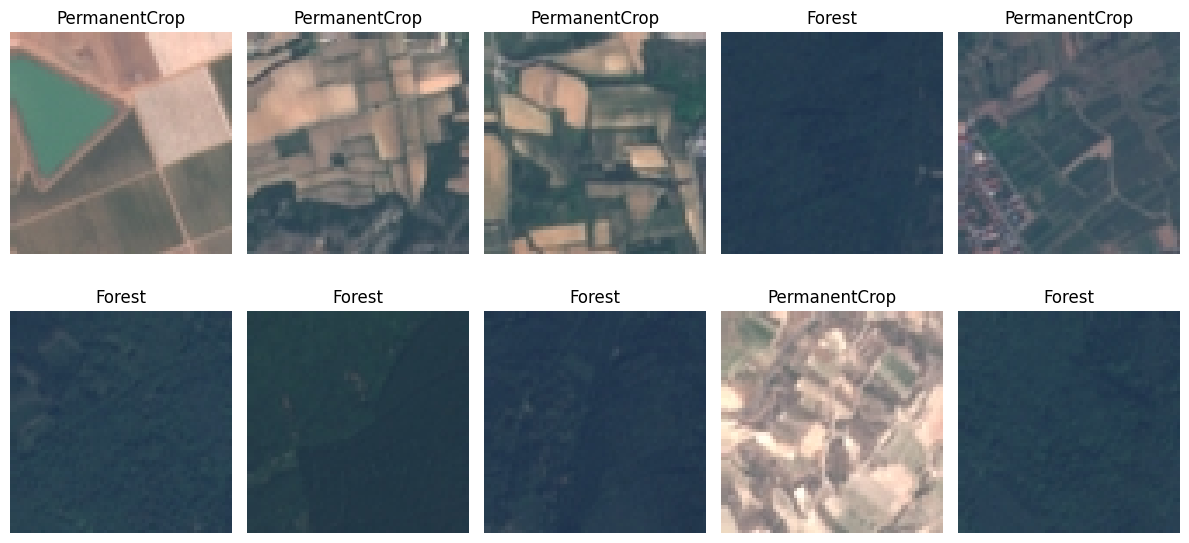

In [65]:
n_show = 10
fig, axes = plt.subplots(2, n_show//2, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    row = subset.iloc[i]
    img_path = os.path.join(DATASET_PATH, row["Filename"])
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.set_title(row["ClassName"])
    ax.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
#MAIN CLASSIFICATION FUNCs
def calculate_img_metrics(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    return {
        "mean_hue": float(np.mean(hsv[:,:,0])),
        "mean_sat": float(np.mean(hsv[:,:,1])),
        "mean_val": float(np.mean(hsv[:,:,2]))
    }

def classify_img(metrics):
    h, s, v = metrics["mean_hue"], metrics["mean_sat"], metrics["mean_val"]
    if h > 90 and s > 80 and v < 90: 
        return "Forest"
    else:
        return "PermanentCrop"


In [68]:
#OUTPUTS METRICS FOR FAILED IMG
def output_compared_vals(img_path, true_class, predicted_class):
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    mean_hue = np.mean(hsv[:,:,0])
    mean_sat = np.mean(hsv[:,:,1])
    mean_val = np.mean(hsv[:,:,2])
    
    print(f"{os.path.basename(img_path)}")
    print(f"  True: {true_class} | Predicted: {predicted_class}")
    print(f"  Mean hue: {mean_hue:.1f}, sat: {mean_sat:.1f}, val: {mean_val:.1f}\n")
    
    plt.imshow(img)
    plt.title(f"True: {true_class} | Pred: {predicted_class}")
    plt.axis("off")
    plt.show()


In [ ]:
#MAIN ITERATION
results = []

for i, row in subset.iterrows():
    img_path = os.path.join(DATASET_PATH, row["Filename"])
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    metrics = calculate_img_metrics(img)
    predicted = classify_img(metrics)
    results.append({
        "Filename": row["Filename"],
        "TrueClass": row["ClassName"],
        "Predicted": predicted
    })

results_df = pd.DataFrame(results)
results_df.head()


,Filename,TrueClass,Predicted
0,PermanentCrop/PermanentCrop_1073.jpg,PermanentCrop,PermanentCrop
1,PermanentCrop/PermanentCrop_1356.jpg,PermanentCrop,PermanentCrop
2,PermanentCrop/PermanentCrop_2349.jpg,PermanentCrop,PermanentCrop
3,Forest/Forest_1951.jpg,Forest,Forest
4,PermanentCrop/PermanentCrop_336.jpg,PermanentCrop,PermanentCrop


In [ ]:
#ACCURACY
accuracy = (results_df["TrueClass"] == results_df["Predicted"]).mean()
print(f"Загальна точність класифікації: {accuracy:.2f}")

# Підрахунок по кожному класу
class_stats = results_df.groupby("TrueClass")[['TrueClass', 'Predicted']].apply(
    lambda g: (g["TrueClass"] == g["Predicted"]).mean(), 
).reset_index(name="Accuracy")
class_stats


Загальна точність класифікації: 0.95


,TrueClass,Accuracy
0,Forest,0.920354
1,PermanentCrop,0.988506


Таким чином можна підбирати трешхолди на кольори і для інших класів. Але часто цього недостатньо. Тоді можна, наприклад, аналізувати форму контурів:

In [226]:
#MAIN CLASSIFICATION FUNCs
def calculate_img_metrics(img):
    # тут достатньо сірої картинки
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    #шукаємо еджі і перетворюємо їх на великі areas
    edges = cv2.Canny(gray_img, 20, 80)
    kernel1 = np.ones((3,3), np.uint8)
    kernel2 = np.ones((2,2), np.uint8)
    dilated = cv2.dilate(edges, kernel1, iterations=2)
    inverted = cv2.bitwise_not(dilated)
    dilated2 = cv2.dilate(inverted, kernel2, iterations=2)

    contours, _ = cv2.findContours(dilated2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None
    # шукаємо "найсинішу" площу, бо були проблеми з фільтруванням по розміру - програма бачила лише поля
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    best_blue_score = 0
    cnt = None
    for cnt_iter in contours:
        #print('cnt_iter')
        mask_cnt = np.zeros(hsv.shape[:2], dtype=np.uint8)
        cv2.drawContours(mask_cnt, [cnt_iter], -1, 255, -1)
        
        mean_color = cv2.mean(hsv, mask=mask_cnt)
        hue = mean_color[0]
        saturation = mean_color[1]
        
        if 70 <= hue <= 150 and saturation > 30:
            blue_score = saturation
            if blue_score > best_blue_score:
                best_blue_score = blue_score
                cnt = cnt_iter

    if cnt is None:
        return None
    # рахуємо властивості контура
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)

    compactness = 4 * np.pi * area / (perimeter ** 2 + 1e-6) 
    x, y, w, h = cv2.boundingRect(cnt)
    aspect_ratio = max(w, h) / (min(w, h) + 1e-6)


    return {
        "contour_area": area,
        "contour_perimeter": perimeter,
        "compactness": compactness,
        "aspect_ratio": aspect_ratio
    }

def classify_img(metrics):
    if not metrics:
        return "Unknown"
    compactness, aspect_ratio = metrics["compactness"], metrics["aspect_ratio"]
    if compactness < 0.5 and aspect_ratio > 0.8:
        likely = "River"
    elif compactness > 0.5 and aspect_ratio < 2:# and color_std < 25:
        likely = "SeaLake"
    else:
        likely = "Unknown"
    return likely


In [227]:
DATASET_PATH = "datasets/EuroSAT/"
CSV_PATH = DATASET_PATH + "train.csv"

num_samples = 200
df = pd.read_csv(CSV_PATH)

subset = df[df["ClassName"].isin(["River", "SeaLake"])].head(num_samples)
subset.reset_index(drop=True, inplace=True)
subset


results = []

for i, row in subset.iterrows():
    #print('img')
    img_path = os.path.join(DATASET_PATH, row["Filename"])
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    metrics = calculate_img_metrics(img)
    predicted = classify_img(metrics)
    results.append({
        "Filename": row["Filename"],
        "TrueClass": row["ClassName"],
        "Predicted": predicted
    })

results_df = pd.DataFrame(results)
results_df.head()


,Filename,TrueClass,Predicted
0,River/River_398.jpg,River,River
1,SeaLake/SeaLake_2570.jpg,SeaLake,SeaLake
2,SeaLake/SeaLake_2239.jpg,SeaLake,SeaLake
3,SeaLake/SeaLake_1258.jpg,SeaLake,SeaLake
4,River/River_1987.jpg,River,River


In [229]:
#ACCURACY
accuracy = (results_df["TrueClass"] == results_df["Predicted"]).mean()
print(f"Загальна точність класифікації: {accuracy:.2f}")

# Підрахунок по кожному класу
class_stats = results_df.groupby("TrueClass")[['TrueClass', 'Predicted']].apply(
    lambda g: (g["TrueClass"] == g["Predicted"]).mean(), 
).reset_index(name="Accuracy")
class_stats


Загальна точність класифікації: 0.80


,TrueClass,Accuracy
0,River,0.673913
1,SeaLake,0.898148


Як бачимо, accuracy трошки страждає. Набагато краще було б зробити це за допомогою нейронних мереж.

Клітинки для тестів, не для головного алгоритму:

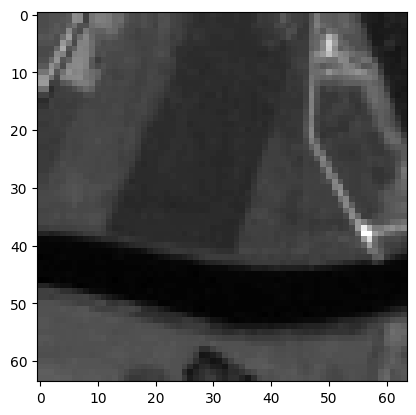

In [ ]:
img_path = os.path.join(DATASET_PATH, "River", "River_5.jpg")
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.imshow(gray_img, cmap='gray')

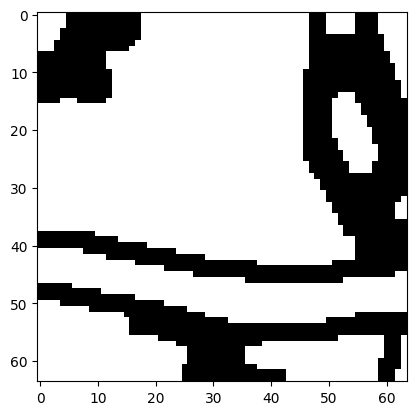

In [186]:
edges = cv2.Canny(gray_img, 20, 80)
kernel1 = np.ones((3,3), np.uint8)
kernel2 = np.ones((2,2), np.uint8)
dilated = cv2.dilate(edges, kernel1, iterations=2)

# Invert so black patches become white
inverted = cv2.bitwise_not(dilated)
dilated2 = cv2.dilate(inverted, kernel2, iterations=2)
plt.imshow(dilated2, cmap='gray')

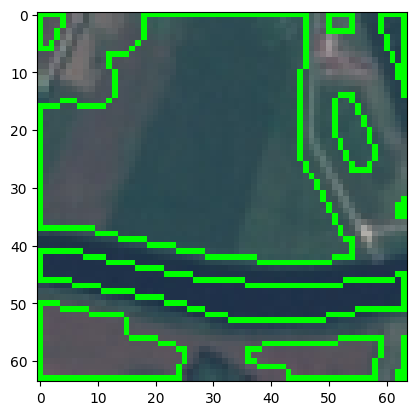

In [ ]:
contours, _ = cv2.findContours(dilated2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
result = img.copy()
cv2.drawContours(result, contours, -1, (0, 255, 0), 1)  # -1 = all contours, green, thickness 2
plt.imshow(result)

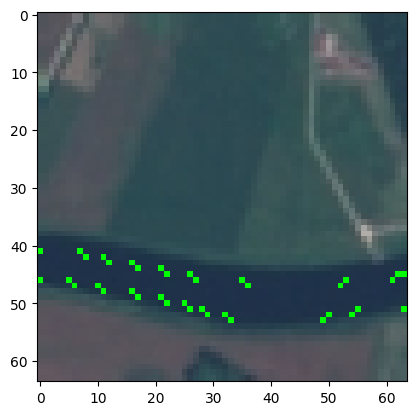

In [196]:
#finds the most blue contour
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
best_blue_score = 0
for cnt_iter in contours:
    mask_cnt = np.zeros(hsv.shape[:2], dtype=np.uint8)
    cv2.drawContours(mask_cnt, [cnt_iter], -1, 255, -1)
    
    mean_color = cv2.mean(hsv, mask=mask_cnt)
    hue = mean_color[0]
    saturation = mean_color[1]
    
    if 80 <= hue <= 140 and saturation > 40:
        blue_score = saturation
        if blue_score > best_blue_score:
            best_blue_score = blue_score
            best_contour = cnt_iter
cnt = best_contour
result = img.copy()
cv2.drawContours(result, cnt, -1, (0, 255, 0), 1)  # -1 = all contours, green, thickness 2
plt.imshow(result)

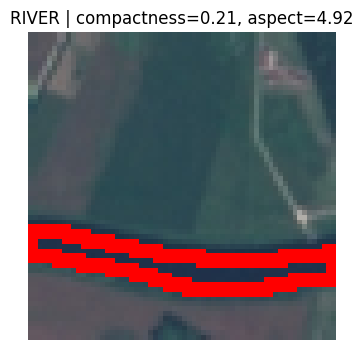

In [197]:
area = cv2.contourArea(cnt)
perimeter = cv2.arcLength(cnt, True)

compactness = 4 * np.pi * area / (perimeter ** 2 + 1e-6)  # ≈1 для кола, <0.3 для річки
x, y, w, h = cv2.boundingRect(cnt)
aspect_ratio = max(w, h) / (min(w, h) + 1e-6)

if compactness < 0.5 and aspect_ratio > 0.8:
    likely = "river"
elif compactness > 0.5 and aspect_ratio < 2:# and color_std < 25:
    likely = "lake"
else:
    likely = "unknown"

vis = img.copy()
cv2.drawContours(vis, [cnt], -1, (255,0,0), 2)
plt.figure(figsize=(6,4))
plt.imshow(vis)
plt.title(f"{likely.upper()} | compactness={compactness:.2f}, aspect={aspect_ratio:.2f}")
plt.axis("off")
plt.show()